# Прогнозирование размеров сварного шва при электронно-лучевой сварке тонкостенных конструкций аэрокосмического назначения

## Описание задачи

В качестве исходных данных были взяты результаты экспериментальных исследований, проводимых в целях улучшения технологического процесса электронно-лучевой сварки изделия, сборка которого состоит из элементов, состоящих из разнородного материала. Установка электронно-лучевой сварки, на которой проводились исследования, предназначена для сварки электронным лучом в глубоком вакууме деталей сборочных единиц из нержавеющих сталей, титановых, алюминиевых и специальных сплавов. Существующая установка электронно-лучевой сварки обеспечивает повторяемость режимов в рамках возможностей реализованной системы управления. Работы по сварке выполнялись на образцах-имитаторах, соответствующих технологическому изделию. Для уменьшения вложения энергии при сварке:

1.	Снижалась величина сварочного тока (IW);
2.	Увеличивался ток фокусировки электронного пучка (IF);
3.	Увеличивалась скорость сварки (VW);
4.	Менялось расстояние от поверхности образцов до электронно-оптической системы (FP). 


По совокупности параметров технологических режимов обеспечивались минимально возможные размеры сварных швов: глубина шва (Depth) и ширина шва (Width).<br/>
В процессе выполнения работ была произведена электронно-лучевая сварка 18-ти единиц образцов. Результаты металлографического контроля по размерам сварного шва для каждого образца проводились в 4-х поперечных сечениях сварного шва. Ускоряющее напряжение было постоянным в диапазоне 19,8 – 20 кВ. Набор полученных данных собраны в составе режимов сварки, размеров сварочных швов в поперечных сечениях всех образцов.

**Требуется:** провести прогнозирование глубины (Depth) и ширины (Width) сварного шва в зависимости от параметров технологического процесса (IW, IF, VW, FP).


### Импорты

In [214]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import set_random_seed
set_random_seed(1982)
import tensorflow
from lightgbm import LGBMRegressor

pd.options.display.float_format = '{:,.2f}'.format

### Загрузка и исследовательский анализ данных

#### Знакомство с данными

In [215]:
df = pd.read_csv('ebw_data.csv')

In [216]:
df.head(15)

,IW,IF,VW,FP,Depth,Width
0,47,139,4.50,80,1.60,2.54
1,47,139,4.50,80,1.62,2.50
2,47,139,4.50,80,1.68,2.60
3,47,139,4.50,80,1.58,2.52
4,45,140,4.50,80,1.76,2.48
5,45,140,4.50,80,1.72,2.48
6,45,140,4.50,80,1.64,2.52
7,45,140,4.50,80,1.64,2.56
8,45,140,8.00,80,1.20,2.00
9,45,140,8.00,80,1.20,1.96


In [217]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IW      72 non-null     int64  
 1   IF      72 non-null     int64  
 2   VW      72 non-null     float64
 3   FP      72 non-null     int64  
 4   Depth   72 non-null     float64
 5   Width   72 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 3.5 KB


Видим, что данные в хорошем состоянии: все колонки числовые и имеют непрерывный тип, пропусков нет, тип данных подходящий(int, float). Сразу бросается в глаза малый размер датасета, что может быть недостаточно для качественного обучения моделей.

In [218]:
df.describe()

,IW,IF,VW,FP,Depth,Width
count,72.00,72.00,72.00,72.00,72.00,72.00
mean,45.67,141.33,8.64,78.33,1.20,1.97
std,1.68,5.15,2.06,21.49,0.23,0.28
min,43.00,131.00,4.50,50.00,0.80,1.68
25%,44.00,139.00,8.00,60.00,1.08,1.76
50%,45.50,141.00,9.00,80.00,1.20,1.84
75%,47.00,146.00,10.00,80.00,1.29,2.05
max,49.00,150.00,12.00,125.00,1.76,2.60


Описательная статистика сообщает нам об адекватных границах диапазона данных и необходимости провести их масштабирование

#### Приведение датасета к целям проекта

    Из проведенного знакомства с данными видно, что данный датасет для обучения моделей в таком виде использовать нельзя.
    
    Для дальнейшей работы нам нужно подготовить датасет так, чтобы при уникальном наборе параметров 'IW', 'IF', 'VW', 'FP' было только одно значение глубины и ширины шва. У нас же несколько измерений при одних и тех же параметрах. 
    
    Также наличие разных значений грубины и ширины шва при одинаковых параметрах 'IW', 'IF', 'VW', 'FP' говорит нам о некой погрешности работы оборудования, которую можно рассчитать и сравнить с результатами работы модели.

In [219]:
df_mod = df.groupby(['IW', 'IF', 'VW', 'FP'], as_index=False).mean()
df_mod

,IW,IF,VW,FP,Depth,Width
0,43,146,9.00,60,1.22,1.77
1,43,150,9.00,50,1.08,1.81
2,44,146,9.00,60,1.23,1.79
3,45,140,4.50,80,1.69,2.51
4,45,140,8.00,80,1.19,1.97
5,45,141,10.00,80,1.01,1.86
6,45,146,9.00,60,1.31,1.76
7,46,141,10.00,80,1.14,1.82
8,46,146,10.00,60,1.31,1.77
9,47,134,10.00,110,0.94,1.94


В результате группировки и усреднения целевых признаков получены данные с необходимой зависимостью. Однако в ходе данных процедур, наш датасет похудел более чем в 4 раза, что еще больше уменьшило шансы качественно обучить модель.

Для оценки погрешности работы оборудования при одних и тех же параметрах рассчитаем стандартное отклонение для каждого набора параметров и добавим его в датасет.

In [220]:
df_std = df.groupby(['IW', 'IF', 'VW', 'FP'], as_index=False).std()[['Depth', 'Width']]
df_std

,Depth,Width
0,0.02,0.03
1,0.00,0.01
2,0.05,0.08
3,0.06,0.04
4,0.02,0.02
5,0.03,0.03
6,0.04,0.00
7,0.10,0.04
8,0.06,0.02
9,0.02,0.06


In [221]:
df_std = df_mod.join(df_std, rsuffix='_std')
df_std

,IW,IF,VW,FP,Depth,Width,Depth_std,Width_std
0,43,146,9.00,60,1.22,1.77,0.02,0.03
1,43,150,9.00,50,1.08,1.81,0.00,0.01
2,44,146,9.00,60,1.23,1.79,0.05,0.08
3,45,140,4.50,80,1.69,2.51,0.06,0.04
4,45,140,8.00,80,1.19,1.97,0.02,0.02
5,45,141,10.00,80,1.01,1.86,0.03,0.03
6,45,146,9.00,60,1.31,1.76,0.04,0.00
7,46,141,10.00,80,1.14,1.82,0.10,0.04
8,46,146,10.00,60,1.31,1.77,0.06,0.02
9,47,134,10.00,110,0.94,1.94,0.02,0.06


In [222]:
Depth_maxstd = df_std['Depth_std'].max()
Depth_maxstd

0.1372172417321214

In [223]:
Width_maxstd = df_std['Width_std'].max()
Width_maxstd

0.07914313844949773

Мы получили максимальные отклонения в глубине и ширине шва в работе оборудования на одинаковых параметрах. Ввиду этого можно считать, что, если ошибка наших моделей будет близка к величине этих отклонений, то модель работает хорошо. 


#### Анализ выбросов

<AxesSubplot:>

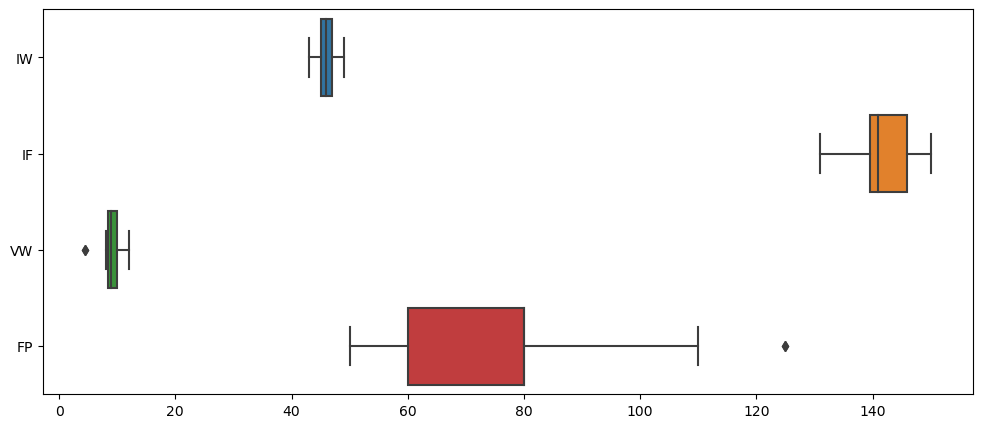

In [224]:
plt.figure(figsize=(12, 5))
sns.boxplot(data=df_mod[['IW', 'IF', 'VW', 'FP']], orient='h')

Из графика "Ящик с усами" видим пару выбросов. Учитывая микроскопический размер нашего датасета, это могут оказаться вовсе и не выбросы. Однако удаление выбросов по признаку FP значительно повышает результаты тестирования моделей и мы все же удалим эти выбросы.

In [225]:
df_mod = df_mod.query('FP < 120')
df_mod

,IW,IF,VW,FP,Depth,Width
0,43,146,9.00,60,1.22,1.77
1,43,150,9.00,50,1.08,1.81
2,44,146,9.00,60,1.23,1.79
3,45,140,4.50,80,1.69,2.51
4,45,140,8.00,80,1.19,1.97
5,45,141,10.00,80,1.01,1.86
6,45,146,9.00,60,1.31,1.76
7,46,141,10.00,80,1.14,1.82
8,46,146,10.00,60,1.31,1.77
9,47,134,10.00,110,0.94,1.94


#### Анализ взаимозависимостей признаков

Для оценки взаимозависимостей признаков и целевых признаков, а также для понимания распределений значений построим матрицу парных графиков.

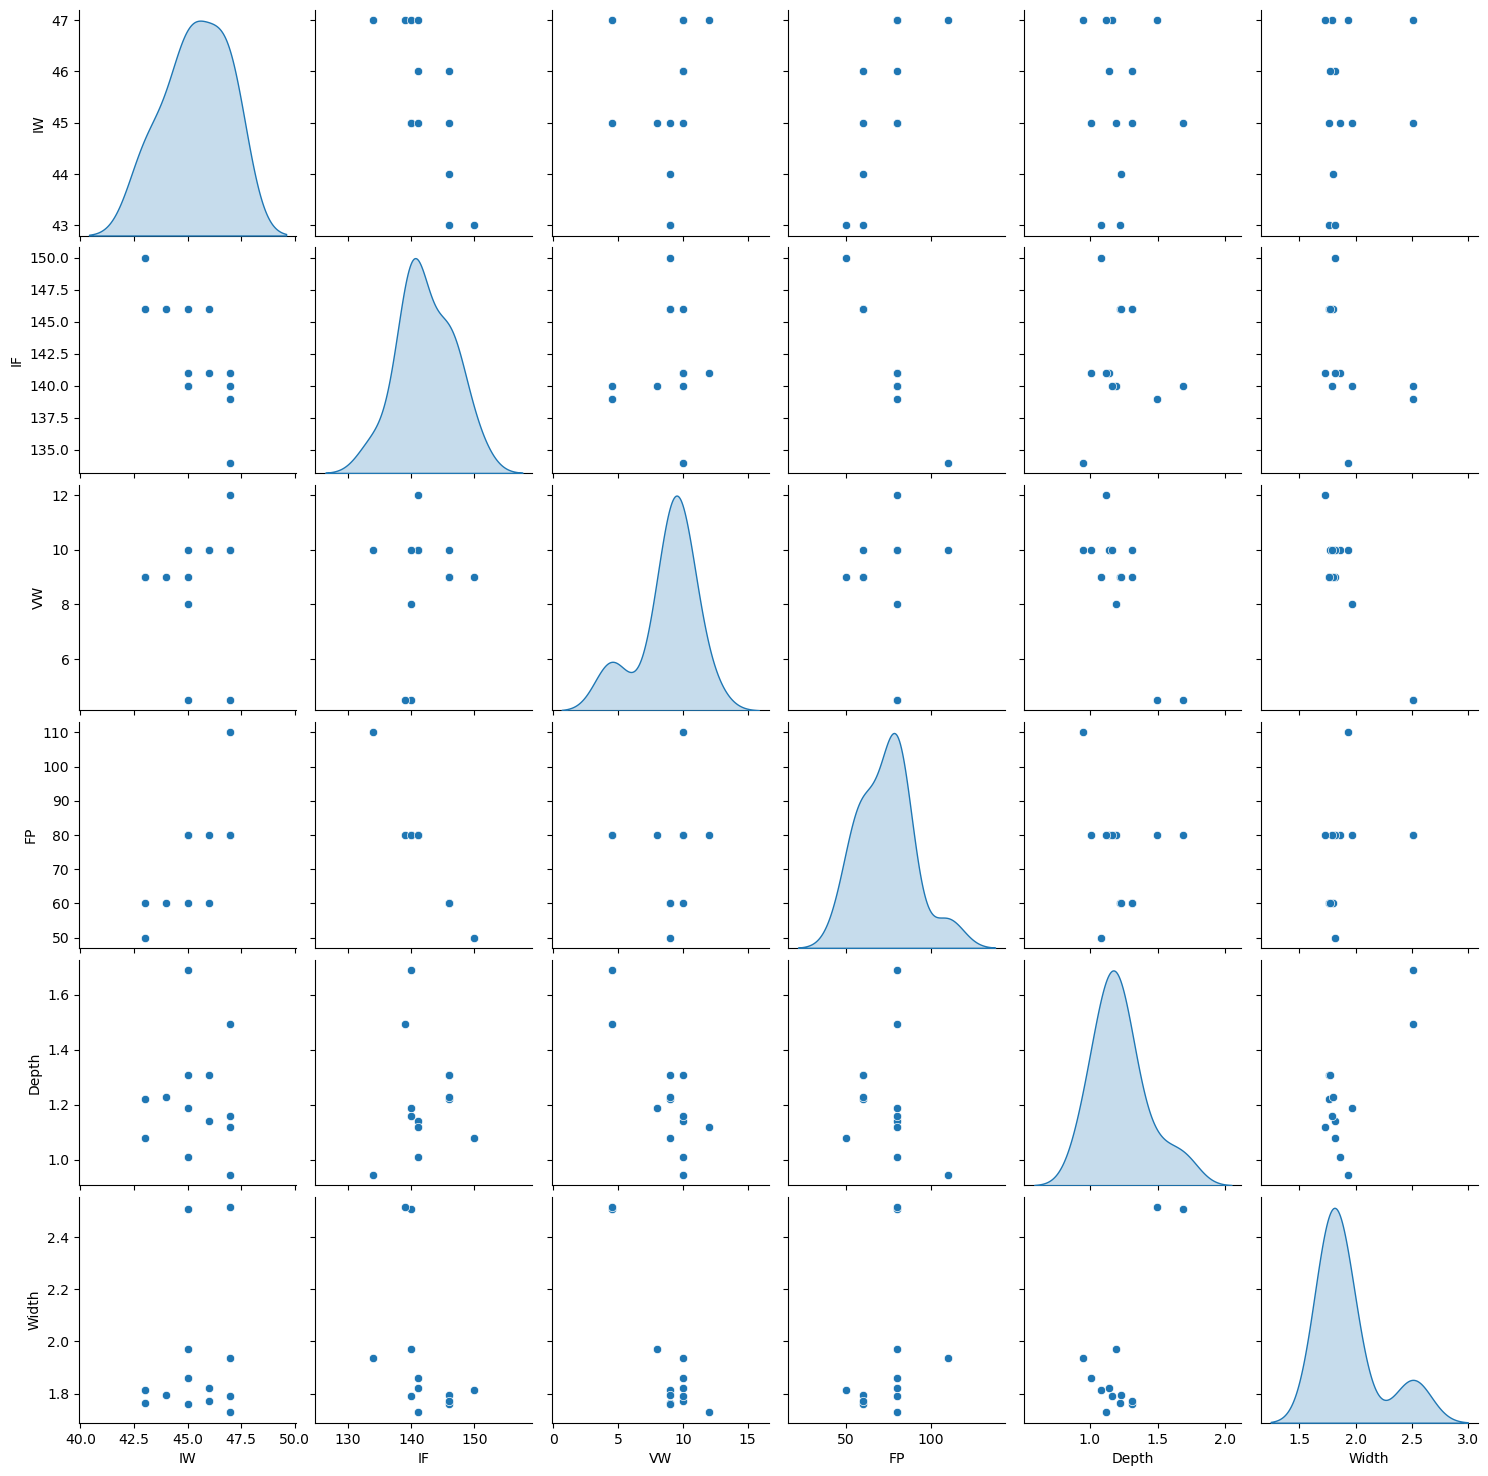

In [226]:
sns.pairplot(df_mod, diag_kind='kde')
plt.show()

Поскольку данных мало, четкая зависимость между признаками не прослеживается. Распределения значений всех признаков близки к нормальному. Для верности построим тепловую карту коэффициентов корреляции.

<AxesSubplot:>

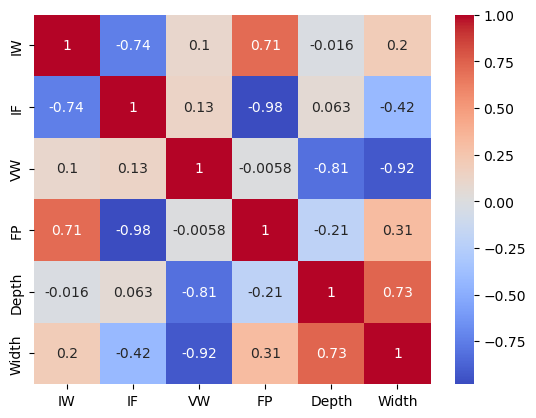

In [227]:
sns.heatmap(df_mod.corr(), annot = True, cmap = 'coolwarm')

Видим высокую зависимость между некоторыми объясняющими признаками - мультиколлинеарность, которая может негативно сказаться на работе линейных моделей.

Удалим один из признаков для устранения этого эффекта. Пусть это будет IW

### Подготовка данных

#### Выделение целевых признаков и разбивка на обучающую и тестовую выборки

In [228]:
X = np.array(df_mod.drop(['IW','Depth', 'Width'], axis=1))
y_depth = np.array(df_mod['Depth'])
y_width = np.array(df_mod['Width'])

In [229]:
X

array([[146. ,   9. ,  60. ],
       [150. ,   9. ,  50. ],
       [146. ,   9. ,  60. ],
       [140. ,   4.5,  80. ],
       [140. ,   8. ,  80. ],
       [141. ,  10. ,  80. ],
       [146. ,   9. ,  60. ],
       [141. ,  10. ,  80. ],
       [146. ,  10. ,  60. ],
       [134. ,  10. , 110. ],
       [139. ,   4.5,  80. ],
       [140. ,  10. ,  80. ],
       [141. ,  12. ,  80. ]])

In [230]:
X_train, X_test, y_depth_train, y_depth_test, y_width_train, y_width_test = train_test_split(X, y_depth, y_width,
                                                                                             test_size=0.2, shuffle=True,
                                                                                             random_state=1982)
X_train.shape, X_test.shape


((10, 3), (3, 3))

#### Стандартизация данных

In [231]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_train, X_test

(array([[ 0.83982531,  0.46080784, -0.86164044],
        [-1.88393244,  0.46080784,  2.21564684],
        [-0.29507376,  1.54506158,  0.36927447],
        [-0.52205357,  0.46080784,  0.36927447],
        [ 1.74774455, -0.08131903, -1.47709789],
        [-0.74903338, -2.52088994,  0.36927447],
        [ 0.83982531, -0.08131903, -0.86164044],
        [-0.52205357, -0.6234459 ,  0.36927447],
        [ 0.83982531, -0.08131903, -0.86164044],
        [-0.29507376,  0.46080784,  0.36927447]]),
 array([[-0.52205357, -2.52088994,  0.36927447],
        [ 0.83982531, -0.08131903, -0.86164044],
        [-0.29507376,  0.46080784,  0.36927447]]))

### Обучение и тестирование моделей

In [232]:
# создадим словари для сохранения результатов теста моделей для каждого целевого признака отдельно

y_depth_test_results = dict()
y_width_test_results = dict()

# добавим туда максимальные погрешности работы сварочного оборудования при статических признаках
y_depth_test_results['static_error'] = Depth_maxstd
y_width_test_results['static_error'] = Width_maxstd


Напишем функцию для визуализации предсказаний на всем датасете обученной модели, т.к. тестовая выборка крайне мала и не наглядна.

In [233]:
def predict_vizual(y, model):
    X_all = np.concatenate((X_train, X_test))
    y_pred = model.predict(X_all)
    plt.figure(figsize=(17,5))
    plt.title(f'Визуализация предсказаний модели: {str(model)}')
    plt.scatter([i for i in range(len(y))], y, label='y')
    plt.scatter([i for i in range(len(y_pred))], y_pred, label='y_pred')
    plt.legend(loc='best')
    plt.xlabel('Количество наблюдений')
    plt.ylim(0, 5)
    plt.show()

## Примитивная модель (среднее значение)

In [234]:
model = 'Dummy'
y_depth_pred = len(X_test) * [y_depth.mean()]
rmse = mean_squared_error(y_depth_test, y_depth_pred, squared=False)
y_depth_test_results[str(model)] = rmse
rmse

0.27384111202503625

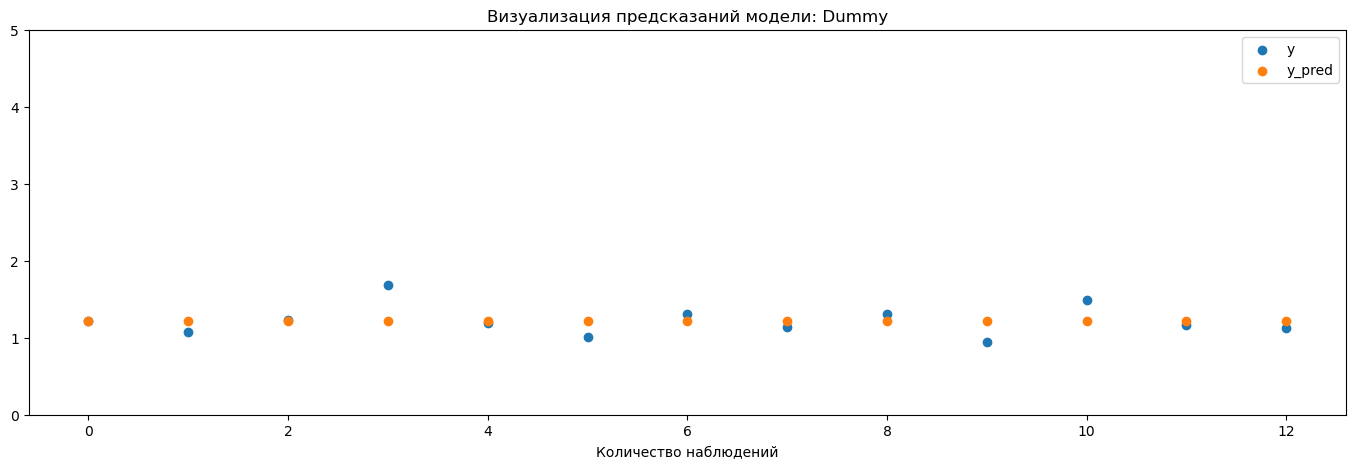

In [235]:
plt.figure(figsize=(17,5))
plt.title(f'Визуализация предсказаний модели: Dummy')
plt.scatter([i for i in range(len(y_depth))], y_depth, label='y')
plt.scatter([i for i in range(len(y_depth))], len(X) * [y_depth.mean()], label='y_pred')
plt.legend(loc='best')
plt.xlabel('Количество наблюдений')
plt.ylim(0, 5)
plt.show()

In [236]:
model = 'Dummy'
y_width_pred = len(X_test) * [y_width.mean()]
rmse = mean_squared_error(y_width_test, y_width_pred, squared=False)
y_width_test_results[str(model)] = rmse
rmse

0.3510684417445615

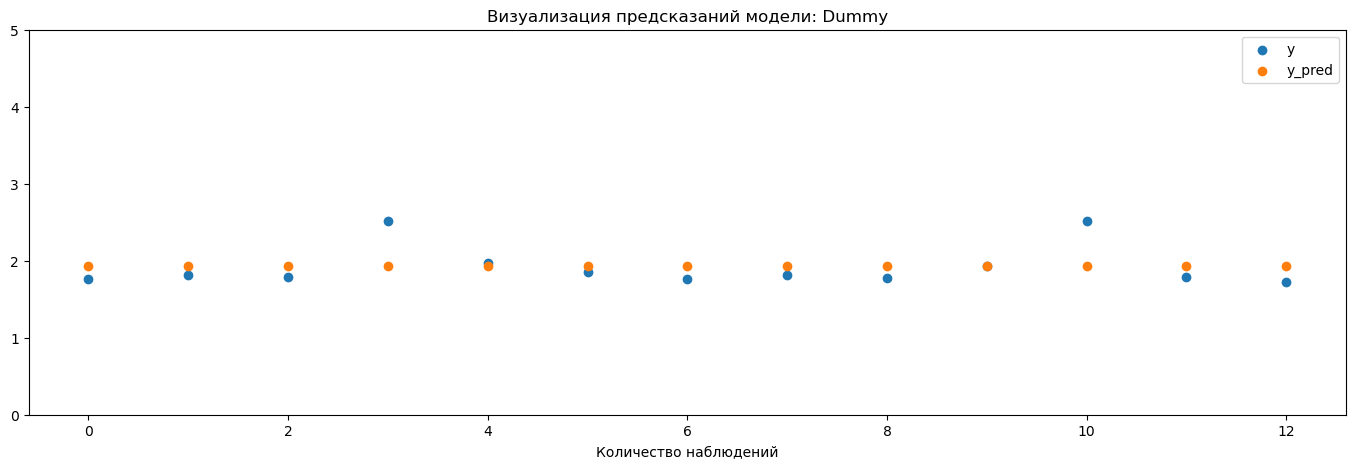

In [237]:
plt.figure(figsize=(17,5))
plt.title(f'Визуализация предсказаний модели: Dummy')
plt.scatter([i for i in range(len(y_width))], y_width, label='y')
plt.scatter([i for i in range(len(y_width))], len(X) * [y_width.mean()], label='y_pred')
plt.legend(loc='best')
plt.xlabel('Количество наблюдений')
plt.ylim(0, 5)
plt.show()

## Линейная регрессия

In [238]:
model = LinearRegression()
model.fit(X_train, y_depth_train)
y_depth_pred = model.predict(X_test)
rmse = mean_squared_error(y_depth_test, y_depth_pred, squared=False)
y_depth_test_results[str(model)] = rmse
rmse

0.2030232515865724

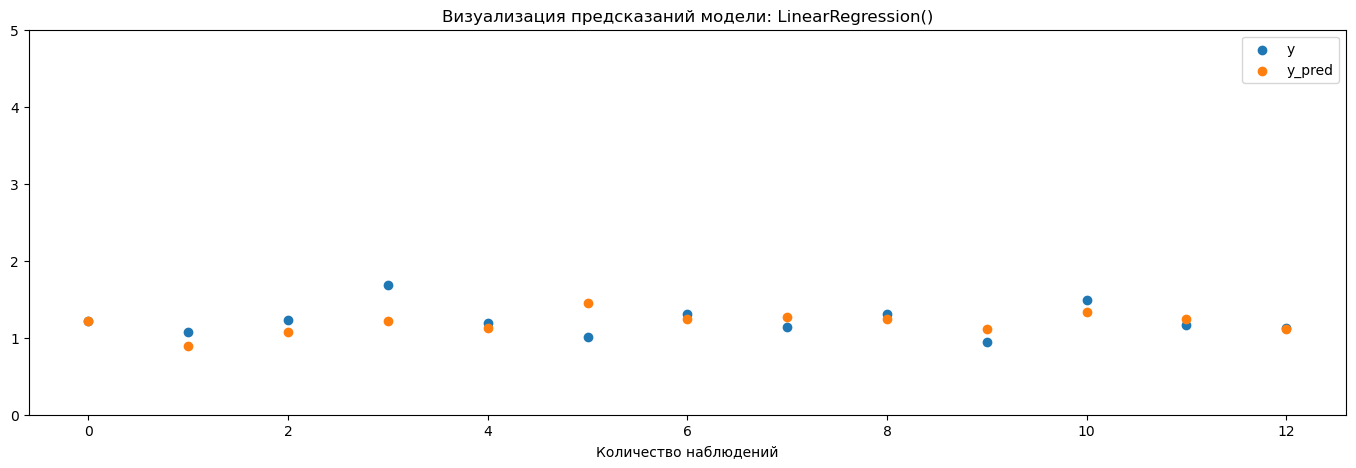

In [239]:
predict_vizual(y_depth, model)

In [240]:
model = LinearRegression()
model.fit(X_train, y_width_train)
y_width_pred = model.predict(X_test)
rmse = mean_squared_error(y_width_test, y_width_pred, squared=False)
y_width_test_results[str(model)] = rmse
rmse

0.05951283612490397

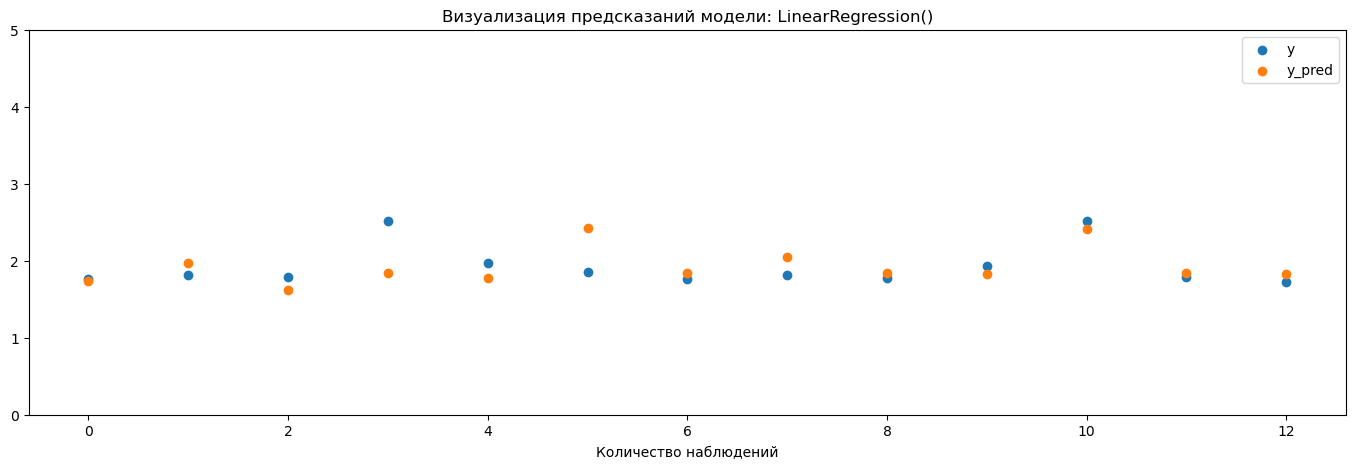

In [241]:
predict_vizual(y_width, model)

## Метод Ridge

In [242]:
model = Ridge(random_state=1982)
model.fit(X_train, y_depth_train)
y_depth_pred = model.predict(X_test)
rmse = mean_squared_error(y_depth_test, y_depth_pred, squared=False)
y_depth_test_results[str(model)] = rmse
rmse

0.17186423742460147

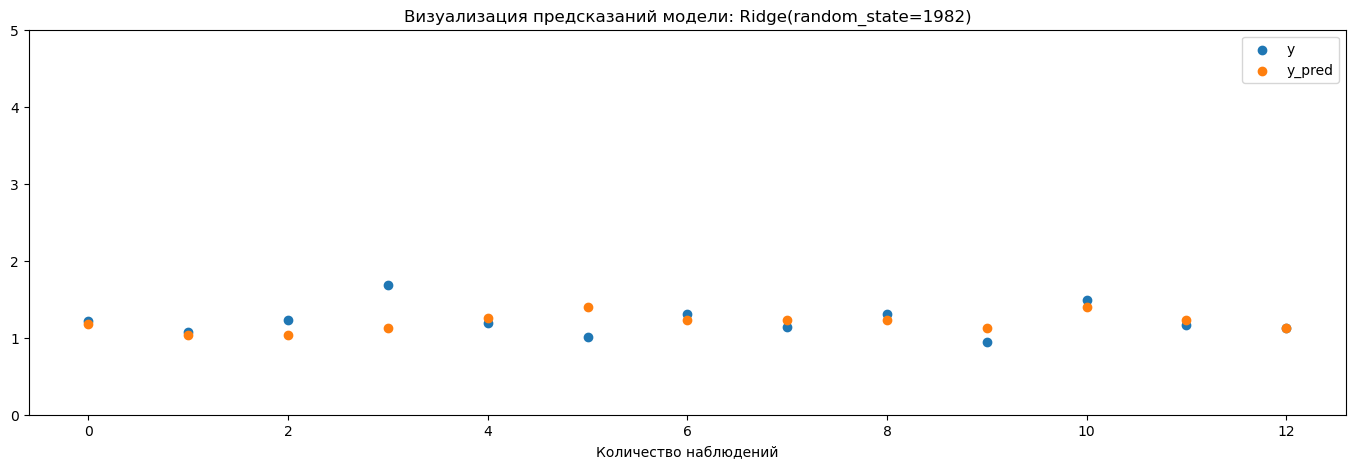

In [243]:
predict_vizual(y_depth, model)

In [244]:
model = Ridge(random_state=1982)
model.fit(X_train, y_width_train)
y_width_pred = model.predict(X_test)
rmse = mean_squared_error(y_width_test, y_width_pred, squared=False)
y_width_test_results[str(model)] = rmse
rmse

0.08535246910911252

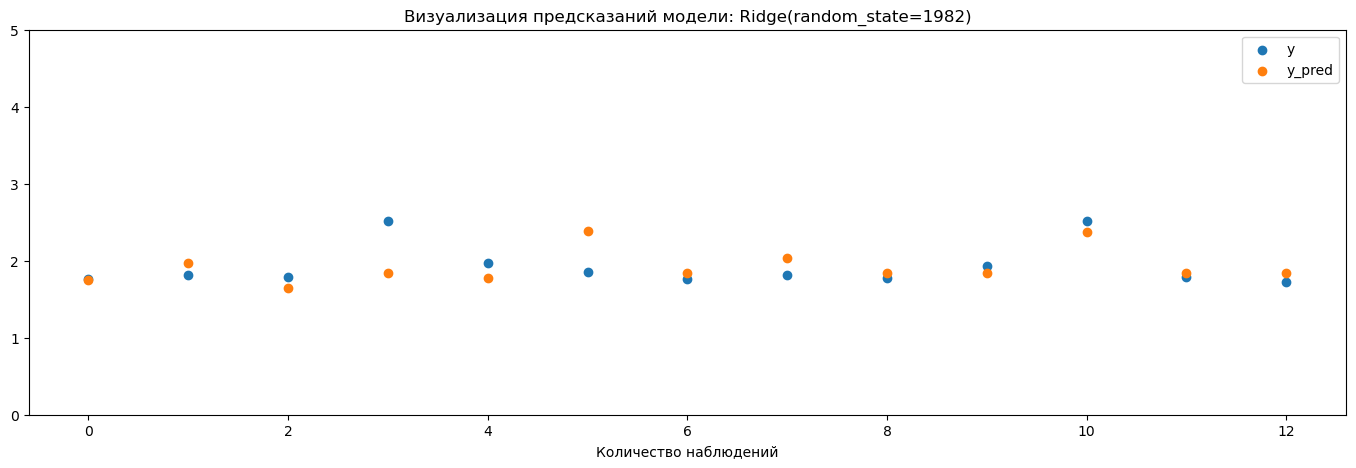

In [245]:
predict_vizual(y_width, model)

## Метод ближайших соседей

In [246]:
model = KNeighborsRegressor()
model.fit(X_train, y_depth_train)
y_depth_pred = model.predict(X_test)
rmse = mean_squared_error(y_depth_test, y_depth_pred, squared=False)
y_depth_test_results[str(model)] = rmse
rmse

0.2652728155440482

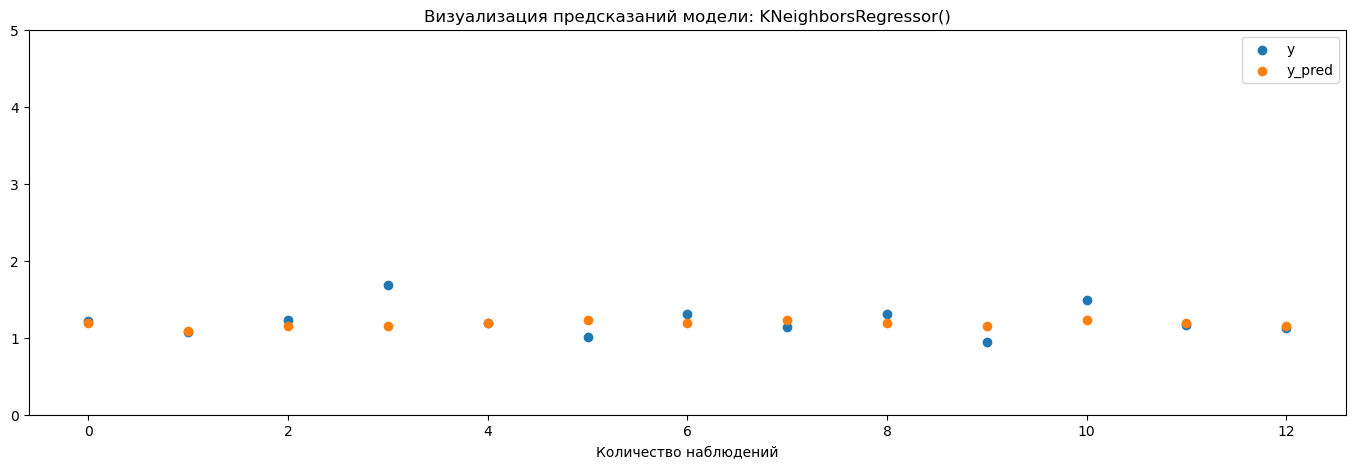

In [247]:
predict_vizual(y_depth, model)

In [248]:
model = KNeighborsRegressor()
model.fit(X_train, y_width_train)
y_width_pred = model.predict(X_test)
rmse = mean_squared_error(y_width_test, y_width_pred, squared=False)
y_width_test_results[str(model)] = rmse
rmse

0.30658019614232523

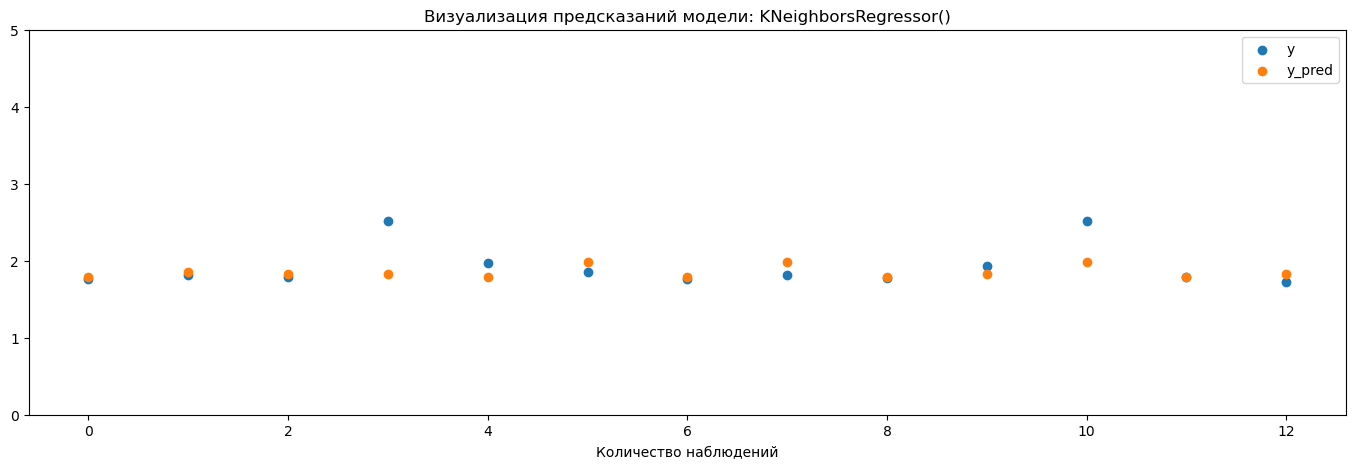

In [249]:
predict_vizual(y_width, model)

## Случайный лес

In [250]:
%%time

model = RandomForestRegressor(random_state=1982)
depth_range = list(range(1, 200))
est_range = list(range(1, 200))
params = {'max_depth': depth_range, 'n_estimators': est_range}
model = RandomizedSearchCV(model, params, n_iter=30, random_state=1982, scoring='neg_mean_squared_error', verbose=1)
model.fit(X_train, y_depth_train)
model_best_params = model.best_params_
model_best_params

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Wall time: 14.8 s


{'n_estimators': 73, 'max_depth': 149}

In [251]:
model = RandomForestRegressor(**model_best_params, random_state=1982)
model.fit(X_train, y_depth_train)
y_depth_pred = model.predict(X_test)
rmse = mean_squared_error(y_depth_test, y_depth_pred, squared=False)
y_depth_test_results[str(model)] = rmse
rmse

0.21932049211961288

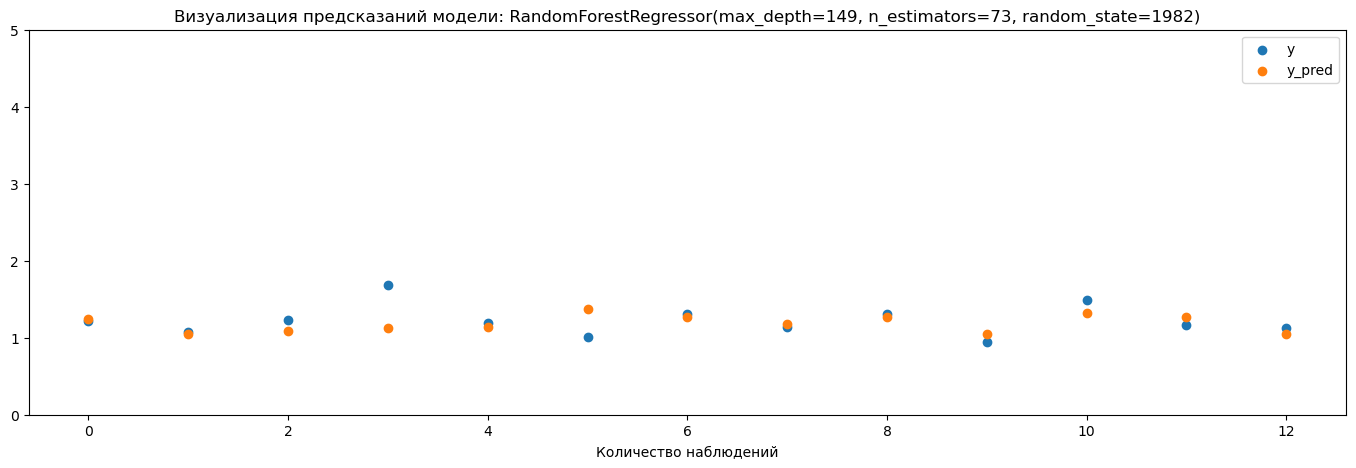

In [252]:
predict_vizual(y_depth, model)

In [253]:
%%time

model = RandomForestRegressor(random_state=1982)
depth_range = list(range(1, 200))
est_range = list(range(1, 200))
params = {'max_depth': depth_range, 'n_estimators': est_range}
model = RandomizedSearchCV(model, params, n_iter=30, random_state=1982, scoring='neg_mean_squared_error', verbose=1)
model.fit(X_train, y_width_train)
model_best_params = model.best_params_
model_best_params

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Wall time: 16.1 s


{'n_estimators': 194, 'max_depth': 25}

In [254]:
model = RandomForestRegressor(**model_best_params, random_state=1982)
model.fit(X_train, y_width_train)
y_width_pred = model.predict(X_test)
rmse = mean_squared_error(y_width_test, y_width_pred, squared=False)
y_width_test_results[str(model)] = rmse
rmse

0.1604887928566208

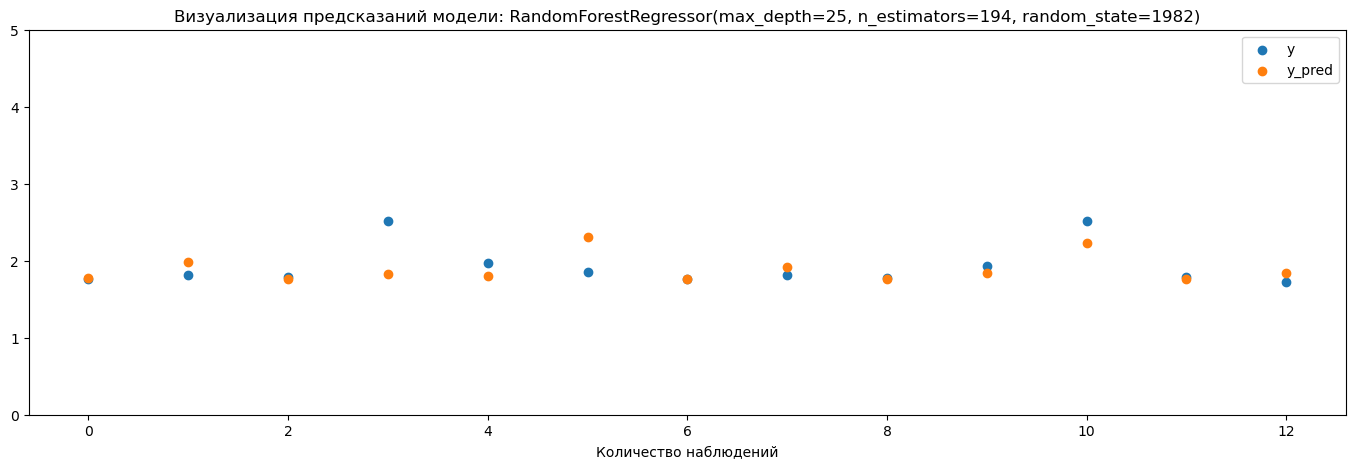

In [255]:
predict_vizual(y_width, model)

## Градиентный бустинг

In [256]:
%%time

model = LGBMRegressor(random_state=1982)
depth_range = list(range(1, 500))
est_range = list(range(1, 500))
speed_range = [0.03, 0.1, 0.5, 0.7, 1]
params = {'max_depth': depth_range, 'n_estimators': est_range, 'learning_rate': speed_range}
model = RandomizedSearchCV(model, params, n_iter=100, random_state=1982, scoring='neg_mean_squared_error', verbose=1)
model.fit(X_train, y_depth_train)
model_best_params = model.best_params_
model_best_params

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Wall time: 6.63 s


{'n_estimators': 31, 'max_depth': 155, 'learning_rate': 1}

In [257]:
model = LGBMRegressor(**model_best_params, random_state=1982)
model.fit(X_train, y_depth_train)
y_depth_pred = model.predict(X_test)
rmse = mean_squared_error(y_depth_test, y_depth_pred, squared=False)
y_depth_test_results[str(model)] = rmse
rmse

0.29444184636051424

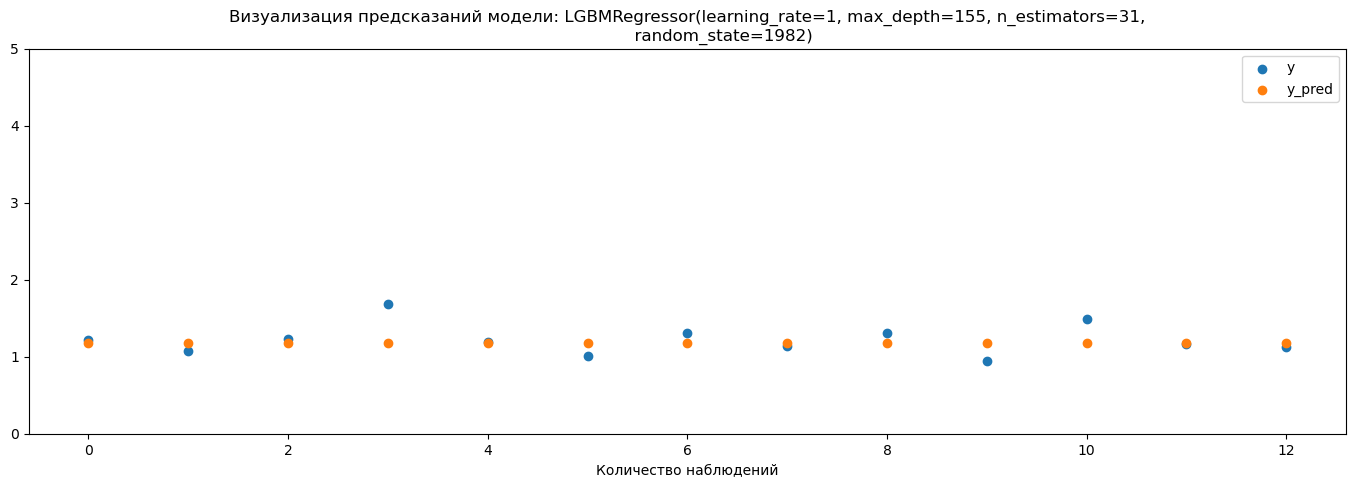

In [258]:
predict_vizual(y_depth, model)

In [259]:
%%time

model = LGBMRegressor(random_state=1982)
depth_range = list(range(1, 500))
est_range = list(range(1, 500))
speed_range = [0.03, 0.1, 0.5, 0.7, 1]
params = {'max_depth': depth_range, 'n_estimators': est_range, 'learning_rate': speed_range}
model = RandomizedSearchCV(model, params, n_iter=100, random_state=1982, scoring='neg_mean_squared_error', verbose=1)
model.fit(X_train, y_width_train)
model_best_params = model.best_params_
model_best_params

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Wall time: 6.5 s


{'n_estimators': 31, 'max_depth': 155, 'learning_rate': 1}

In [260]:
model = LGBMRegressor(**model_best_params, random_state=1982)
model.fit(X_train, y_width_train)
y_width_pred = model.predict(X_test)
rmse = mean_squared_error(y_width_test, y_width_pred, squared=False)
y_width_test_results[str(model)] = rmse
rmse

0.36407150621333695

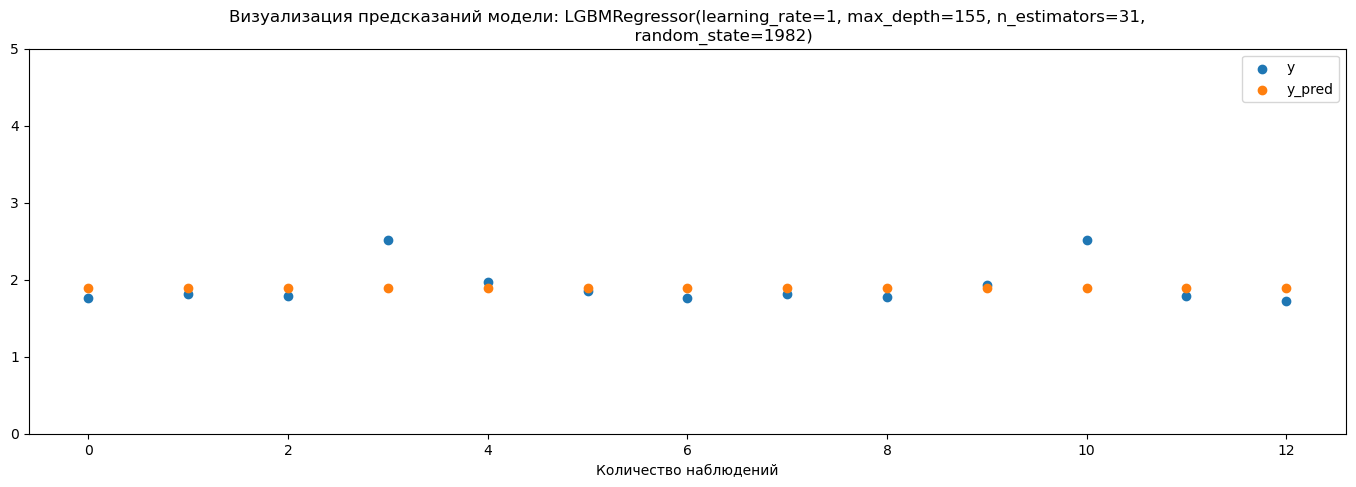

In [261]:
predict_vizual(y_width, model)

## Полносвязная нейронная сеть

### с одним нейроном

In [262]:
set_random_seed(1982)

model = Sequential()
model.add(Dense(1, activation='elu', input_dim=3))

model.compile(optimizer='Adam', loss='mean_absolute_error')
model.fit(X_train, y_depth_train, epochs=1000, verbose=0)
y_depth_pred = model.predict(X_test)
rmse = mean_squared_error(y_depth_test, y_depth_pred, squared=False)
y_depth_test_results[str(model)] = rmse
rmse    

1/1 [==============================] - 0s 38ms/step


0.25335868386189125

1/1 [==============================] - 0s 20ms/step


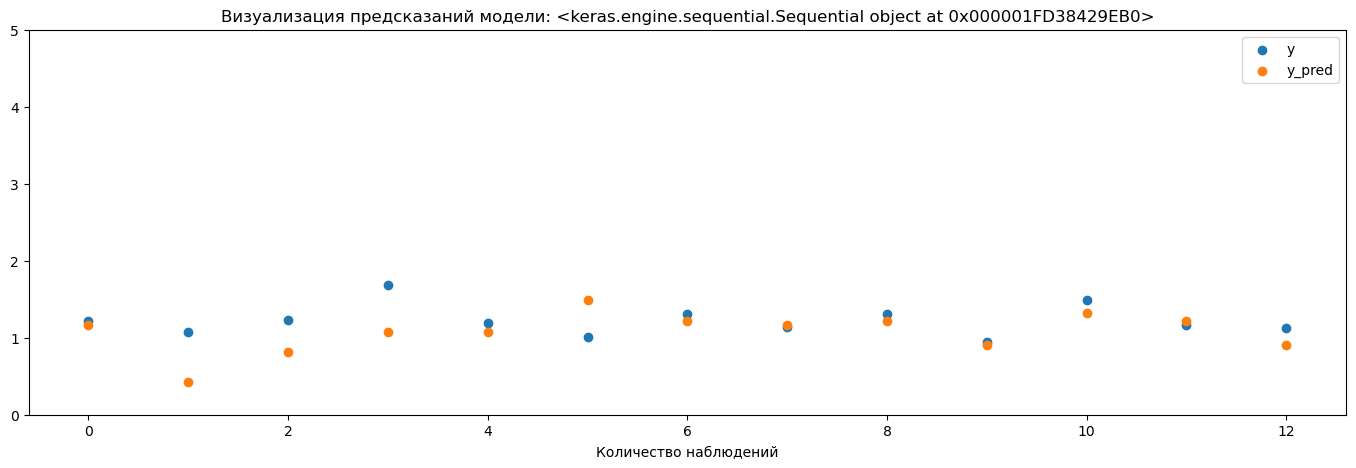

In [263]:
predict_vizual(y_depth, model)

In [264]:
set_random_seed(1982)

model = Sequential()
model.add(Dense(1, activation='elu', input_dim=3))

model.compile(optimizer='Adam', loss='mean_absolute_error')

model.fit(X_train, y_width_train, epochs=1000, verbose=0)
y_width_pred = model.predict(X_test)
rmse = mean_squared_error(y_width_test, y_width_pred, squared=False)
y_width_test_results[str(model)] = rmse
rmse    

1/1 [==============================] - 0s 37ms/step


0.8076356345705977

1/1 [==============================] - 0s 19ms/step


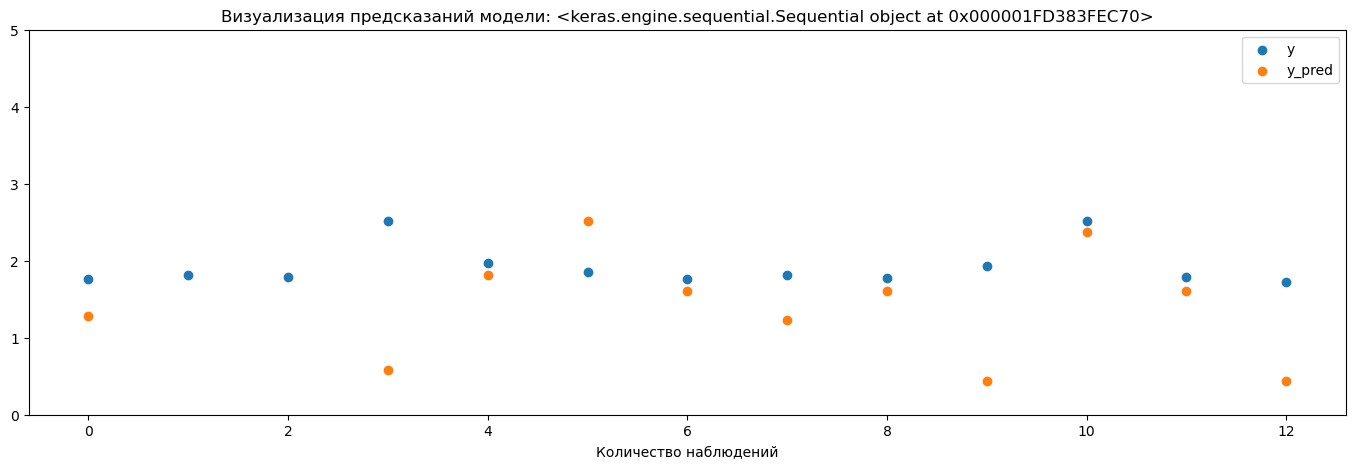

In [265]:
predict_vizual(y_width, model)

### многослойная сеть

In [266]:
set_random_seed(1982)

model = Sequential()
model.add(Dense(64, activation='elu', input_dim=3))
#model.add(Dropout(0.2))
model.add(Dense(64, activation='elu'))

model.add(Dense(64, activation='elu'))

model.add(Dense(1))
model.compile(optimizer='Adam', loss='mean_absolute_error')

model.fit(X_train, y_depth_train, epochs=1000, verbose=0)
y_depth_pred = model.predict(X_test)
rmse = mean_squared_error(y_depth_test, y_depth_pred, squared=False)
y_depth_test_results[str(model)] = rmse
rmse    

1/1 [==============================] - 0s 52ms/step


0.22975096697535463

1/1 [==============================] - 0s 20ms/step


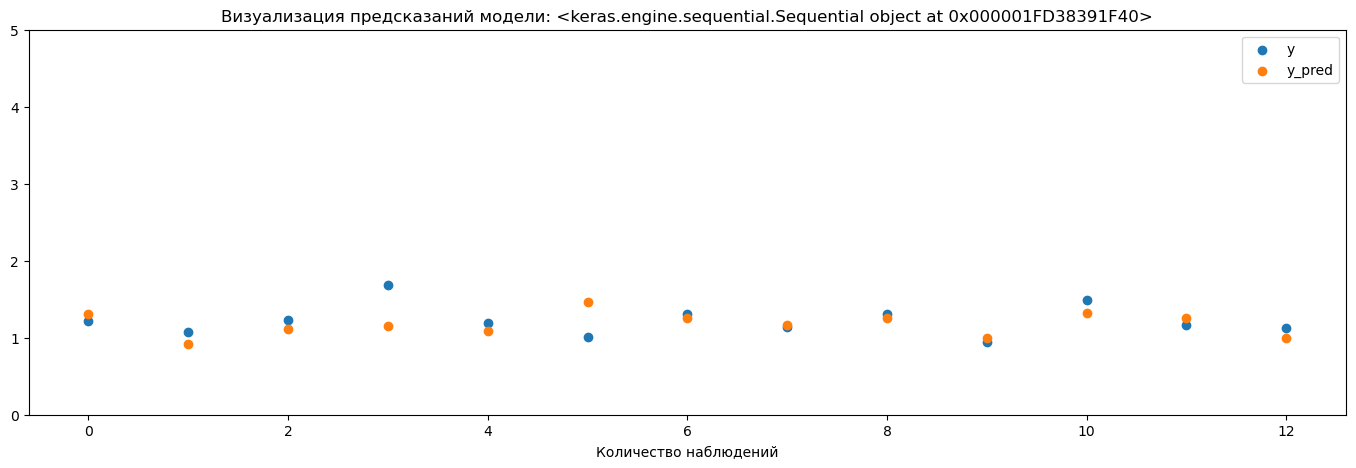

In [267]:
predict_vizual(y_depth, model)

In [268]:
set_random_seed(1982)

model = Sequential()
model.add(Dense(64, activation='elu', input_dim=3))
#model.add(Dropout(0.2))
model.add(Dense(64, activation='elu'))

model.add(Dense(64, activation='elu'))

model.add(Dense(1))
model.compile(optimizer='Adam', loss='mean_absolute_error')

model.fit(X_train, y_width_train, epochs=1000, verbose=0)
y_width_pred = model.predict(X_test)
rmse = mean_squared_error(y_width_test, y_width_pred, squared=False)
y_width_test_results[str(model)] = rmse
rmse    

1/1 [==============================] - 0s 60ms/step


0.01669026256235321

1/1 [==============================] - 0s 25ms/step


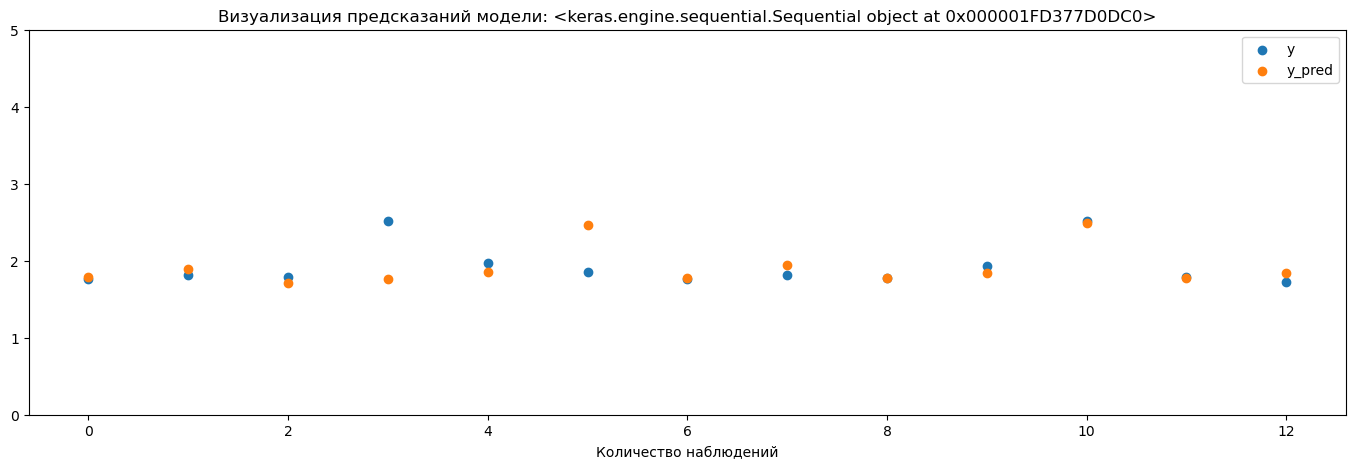

In [269]:
predict_vizual(y_width, model)

## Анализ итогов тестирования. Выбор модели

In [270]:
y_depth_test_results = pd.DataFrame.from_dict(y_depth_test_results, orient='index')
y_depth_test_results.columns = ['RMSE']
y_depth_test_results

,RMSE
static_error,0.14
Dummy,0.27
LinearRegression(),0.20
Ridge(random_state=1982),0.17
KNeighborsRegressor(),0.27
"RandomForestRegressor(max_depth=149, n_estimators=73, random_state=1982)",0.22
"LGBMRegressor(learning_rate=1, max_depth=155, n_estimators=31,\n random_state=1982)",0.29
<keras.engine.sequential.Sequential object at 0x000001FD38429EB0>,0.25
<keras.engine.sequential.Sequential object at 0x000001FD38391F40>,0.23


In [271]:
y_width_test_results = pd.DataFrame.from_dict(y_width_test_results, orient='index')
y_width_test_results.columns = ['RMSE']
y_width_test_results

,RMSE
static_error,0.08
Dummy,0.35
LinearRegression(),0.06
Ridge(random_state=1982),0.09
KNeighborsRegressor(),0.31
"RandomForestRegressor(max_depth=25, n_estimators=194, random_state=1982)",0.16
"LGBMRegressor(learning_rate=1, max_depth=155, n_estimators=31,\n random_state=1982)",0.36
<keras.engine.sequential.Sequential object at 0x000001FD383FEC70>,0.81
<keras.engine.sequential.Sequential object at 0x000001FD377D0DC0>,0.02


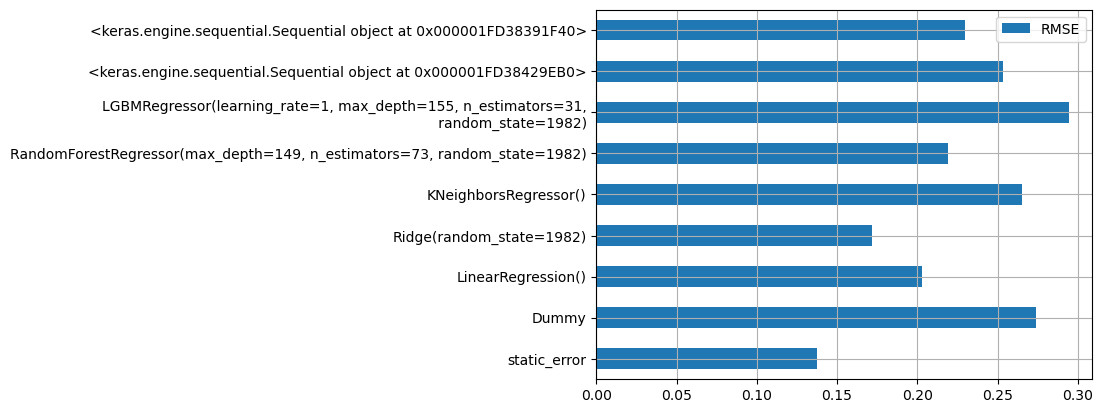

In [272]:
y_depth_test_results.plot(kind='barh', grid=True)
plt.show()

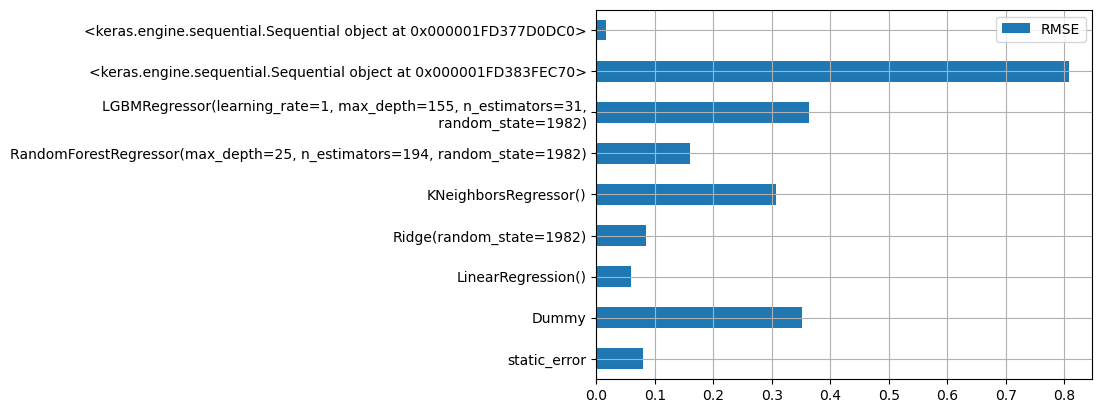

In [273]:
y_width_test_results.plot(kind='barh', grid=True)
plt.show()

## Выводы

1. Очевидно, что для нормального обучения и тестирования моделей данных слишком мало (это совсем не BigData). Такое небольшое количество наблюдений не дает оснований для уверенности в правильности выявленных моделями зависимостей. Это может быть всего лишь один день в работе оборудования или даже час, и данные результаты наблюдений являются просто исключением из совсем другой совокупности наблюдаемых явлений. Счмтается, что минимальный размер выборки для оценки генеральной совокупности по выборке - 30 элементов. Для выявления наиболее достоверных зависимостей нужны сотни, а то и тысячи измерений.


2. Тем не менее, в ходе исследования и обучения моделей были получены результаты, ошибка которых соизмерима с погрешностью оборудования на статических признаках и существенно ниже примитивной модели. <br/>
Наилучшие результаты по предсказанию целевого признака показывают модели линейной регрессии, в первую очередь модель Ridge, а также простая линейная модель. <br/>
Таже хорошие результаты могут показывать многослойные нейронные сети, однако, если не зафиксировать их первичное случайное распределение весов, то ошибка их работы сильно колеблeтся от случая к случаю, что возможно опять-таки связано с малым размером датасета. На завиксированном (для воспроизводимости) генераторе случайных чисел, многослойная нейросеть для глубины шва показывает ошибку, уступающую моделям линейной регрессии, а для ширины - значительно меньшую, чем для этих моделей.


3. В процессе разведочного анализа данных была установлена высокая корреляция между рядом признаков (мультиколлинеарность), что также нуждается в проверке на большем количестве наблюдений. Если мультиколлинеарность на большом датасете сохранится, то будет необходимо удалить один из взаимозависимых признаков, т.к. это может негативно сказаться на работе линейных моделей.
 